# Overall Equipment Effectiveness (OEE) Analysis for Manufacturing Lines

**Authors:** Wiame El Hafid & Houssam Rjili  
**Date:** May 8, 2025

---

### Abstract

This notebook presents an end-to-end exploration of manufacturing line performance using Overall Equipment Effectiveness (OEE). We first load and preprocess the raw timestamp data, then compute key OEE metrics. Finally, we visualize trends and compare performance across lines to identify opportunities for improvement.


## 1. Setup and Library Imports

In this section, we configure our environment by suppressing non-critical warnings and importing all necessary Python libraries for data handling, visualization, and missing-value inspection.

In [ ]:
!pip install missingno

### 1.1 Library Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime

### 1.2 Warnings Suppressing

In [ ]:
warnings.filterwarnings('ignore')

## 2. Loading The Datasets

Here we load the two datasets `production_line.csv` and `line_status_notcleaned.csv`

In [ ]:
df_ls = pd.read_csv('line_status_notcleaned.csv')
df_prd = pd.read_csv('production_data.csv')

### 2.1 Data Ingestion and Initial Inspection

Here we perform a first glance at `line_status_notcleaned.csv` structure:

- **Rows & Columns**: Number of observations and features  
- **Data Types**: Check for correct parsing of dates and categorical fields  
- **Missing Values**: Identify incomplete records  

In [ ]:
display(df_ls.head())

,PRODUCTION_LINE,SHIFT,START_DATETIME,FINISH_DATETIME,STATUS,IS_DELETED,STATUS_NM,STATUS_NAME,Unnamed: 8
0,LINE-01,1,1/2/23 6:00,1/2/23 6:05,11,0,Meeting,Meeting,NaN
1,LINE-01,1,1/2/23 6:05,1/2/23 8:52,19,0,Other,Other,NaN
2,LINE-01,1,1/2/23 8:52,1/2/23 9:05,1,0,Production,Production,NaN
3,LINE-01,1,1/2/23 9:05,1/2/23 9:27,13,0,Break Time,Break Time,NaN
4,LINE-01,1,1/2/23 9:27,1/2/23 12:05,1,0,Production,Production,NaN


### 2.1.1 DataFrame Structure

Use `df_prd.info()` to verify data types and completeness.

In [ ]:
print(df_ls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38081 entries, 0 to 38080
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PRODUCTION_LINE  38081 non-null  object 
 1   SHIFT            38081 non-null  int64  
 2   START_DATETIME   38081 non-null  object 
 3   FINISH_DATETIME  35800 non-null  object 
 4   STATUS           38081 non-null  int64  
 5   IS_DELETED       38081 non-null  int64  
 6   STATUS_NM        38081 non-null  object 
 7   STATUS_NAME      38081 non-null  object 
 8   Unnamed: 8       2 non-null      float64
dtypes: float64(1), int64(3), object(5)
memory usage: 2.6+ MB
None


### 2.2 Descriptive Statistics

Compute summary statistics for each column to understand distributions, unique value counts, and potential anomalies.  

In [ ]:
display(df_ls.describe(include='all'))

,PRODUCTION_LINE,SHIFT,START_DATETIME,FINISH_DATETIME,STATUS,IS_DELETED,STATUS_NM,STATUS_NAME,Unnamed: 8
count,38081,38081.000000,38081,35800,38081.000000,38081.000000,38081,38081,2.0
unique,4,NaN,22777,22132,NaN,NaN,22,22,NaN
top,LINE-06,NaN,1/31/23 10:33,1/31/23 10:33,NaN,NaN,Production,Production,NaN
freq,10818,NaN,72,73,NaN,NaN,15201,15201,NaN
mean,NaN,1.461884,NaN,NaN,766.601245,0.319293,NaN,NaN,12159.0
std,NaN,0.498552,NaN,NaN,8601.848975,0.466209,NaN,NaN,0.0
min,NaN,1.000000,NaN,NaN,1.000000,0.000000,NaN,NaN,12159.0
25%,NaN,1.000000,NaN,NaN,1.000000,0.000000,NaN,NaN,12159.0
50%,NaN,1.000000,NaN,NaN,12.000000,0.000000,NaN,NaN,12159.0
75%,NaN,2.000000,NaN,NaN,31.000000,1.000000,NaN,NaN,12159.0


## 3. Data Cleaning

### 3.1 Missing-Value Analysis

Visualize missingness patterns to decide on imputation or record removal strategies.

In [ ]:
print(df_ls.isna().sum())

PRODUCTION_LINE        0
SHIFT                  0
START_DATETIME         0
FINISH_DATETIME     2281
STATUS                 0
IS_DELETED             0
STATUS_NM              0
STATUS_NAME            0
Unnamed: 8         38079
dtype: int64


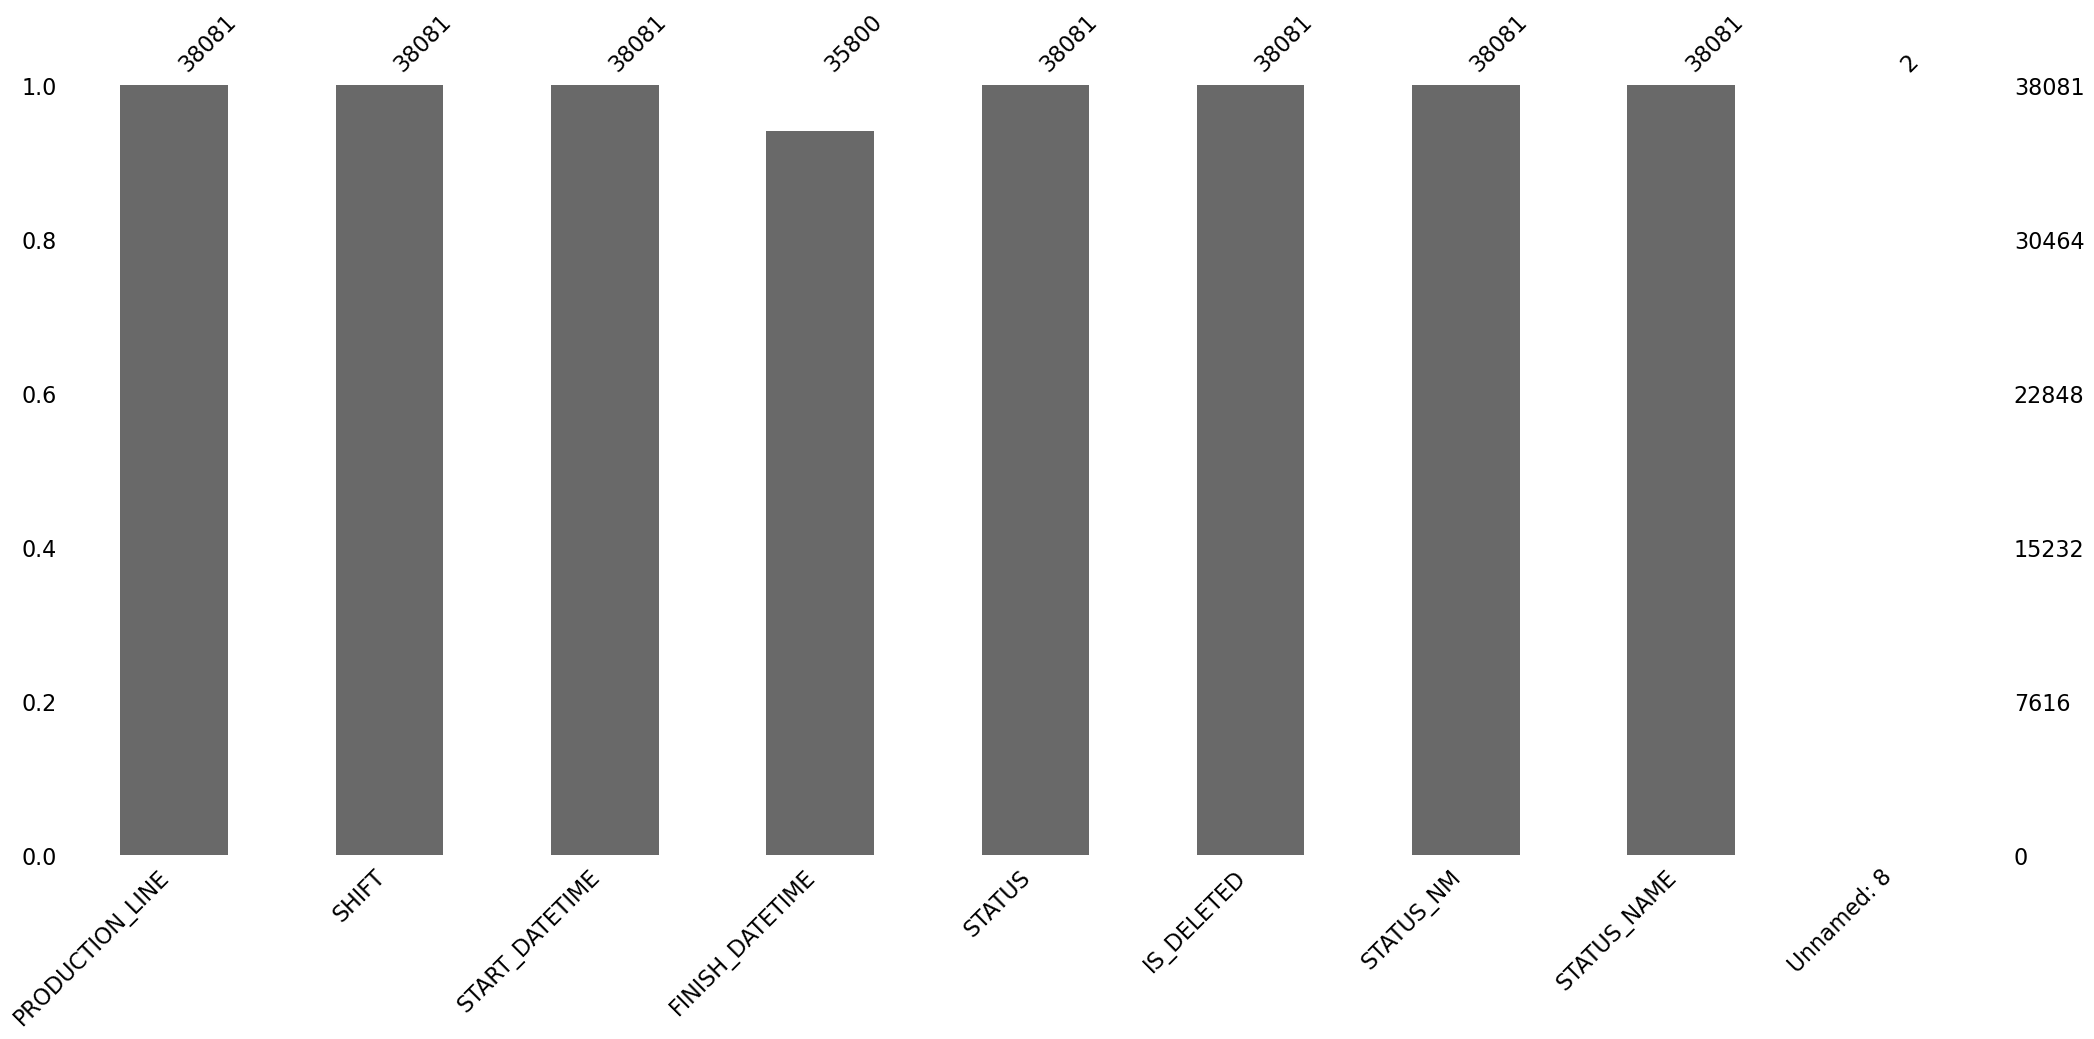

In [ ]:
# Bar chart of missing data
msno.bar(df_ls)
plt.show()

In [ ]:
duplicates = df_ls[df_ls.duplicated(subset=['FINISH_DATETIME'])]
print(f"Number of duplicate rows: {len(duplicates)}")

Number of duplicate rows: 15948


In [ ]:
def check_datetime_format(datetime_str):
    try:
        # Check
        if isinstance(datetime_str, pd.Timestamp) or isinstance(datetime_str, datetime.datetime):
            return True

        # Parse the datetime string
        pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M:%S.%f')
        return True
    except (ValueError, TypeError):
        #  We return False If the format doesn't match
        return False

# Check both columns
df = pd.DataFrame()
df['valid_start'] = df_ls['START_DATETIME'].apply(check_datetime_format)
df['valid_finish'] = df_ls['FINISH_DATETIME'].apply(check_datetime_format)

# Invalid datetime formats
invalid_datetimes = df[(~df['valid_start']) | (~df['valid_finish'])]

# Displaying...
if len(invalid_datetimes) > 0:
    print("Rows with invalid datetime formats:")
else:
    print("All datetime formats are valid.")

# Logical date issues (like finish before start)
df['logical_error'] = df_ls['FINISH_DATETIME'] < df_ls['START_DATETIME']
illogical_dates = df[df['logical_error']]

if len(illogical_dates) > 0:
    print("\nRows where finish time is before start time:", len(illogical_dates))
else:
    print("\nAll datetime sequences are logically valid.")

Rows with invalid datetime formats:

Rows where finish time is before start time: 1360


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Helper Function to Calculate Overlaps
def calculate_overlaps(group):
    """
    Calculates the exact start, end, and duration of time overlaps
    within a sorted group (representing a single production line).

    Args:
        group (pd.DataFrame): A DataFrame subset for a single production line,
                              sorted by START_DATETIME. It must contain
                              'PRODUCTION_LINE', 'START_DATETIME', 'FINISH_DATETIME'.

    Returns:
        pd.DataFrame: A DataFrame with columns ['PRODUCTION_LINE', 'OVERLAP_START',
                      'OVERLAP_END', 'OVERLAP_DURATION', 'RECORD_INDEX_1', 'RECORD_INDEX_2'],
                      listing all overlaps found. Returns an empty DataFrame if no overlaps.
    """
    if len(group) < 2:
        return pd.DataFrame(columns=['PRODUCTION_LINE', 'OVERLAP_START', 'OVERLAP_END',
                                     'OVERLAP_DURATION', 'RECORD_INDEX_1', 'RECORD_INDEX_2'])

    # Ensure sorting by start time
    group = group.sort_values('START_DATETIME').reset_index() # Keep original index if needed

    overlap_data = []
    line_name = group.loc[0, 'PRODUCTION_LINE'] # Get line name

    # Iterate through adjacent pairs of records
    for i in range(len(group) - 1):
        current_record = group.iloc[i]
        next_record = group.iloc[i+1]

        # Check for overlap condition: next record starts before current one finishes
        if next_record['START_DATETIME'] < current_record['FINISH_DATETIME']:
            # Overlap starts when the second record begins
            overlap_start = next_record['START_DATETIME']
            # Overlap ends when the *earlier* of the two finishes
            overlap_end = min(current_record['FINISH_DATETIME'], next_record['FINISH_DATETIME'])
            overlap_duration = overlap_end - overlap_start

            # Only record actual overlaps with positive duration
            if overlap_duration > pd.Timedelta(0):
                overlap_data.append({
                    'PRODUCTION_LINE': line_name,
                    'OVERLAP_START': overlap_start,
                    'OVERLAP_END': overlap_end,
                    'OVERLAP_DURATION': overlap_duration,
                    'RECORD_INDEX_1': current_record['index'], # Original index of first record
                    'RECORD_INDEX_2': next_record['index']  # Original index of second record
                })

    return pd.DataFrame(overlap_data)

# --- Data Preparation ---
df_ls['START_DATETIME'] = pd.to_datetime(df_ls['START_DATETIME'])
df_ls['FINISH_DATETIME'] = pd.to_datetime(df_ls['FINISH_DATETIME'])
df_ls['DURATION'] = df_ls['FINISH_DATETIME'] - df_ls['START_DATETIME']
df_ls = df_ls.reset_index(drop=True).reset_index() # Creates an 'index' column

# --- Calculate Overlaps ---
# Apply the function to each production line
all_overlaps_df = df_ls.groupby('PRODUCTION_LINE', group_keys=False).apply(calculate_overlaps)
if not all_overlaps_df.empty:
    print(f"\nTotal overlap instances found: {len(all_overlaps_df)}")
    print("\nOverlap Duration Stats:")
    display(all_overlaps_df['OVERLAP_DURATION'].describe())
else:
    print("No overlaps found.")


Total overlap instances found: 9670

Overlap Duration Stats:


count                         9670
mean     0 days 00:35:28.064115822
std      0 days 01:52:28.248090187
min                0 days 00:01:00
25%                0 days 00:03:00
50%                0 days 00:12:00
75%                0 days 00:39:00
max                6 days 06:49:00
Name: OVERLAP_DURATION, dtype: object

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# --- Helper Function to Calculate Gaps ---
def calculate_gaps(group):
    """
    Calculates the exact start, end, and duration of time gaps
    within a sorted group (representing a single production line).

    Args:
        group (pd.DataFrame): A DataFrame subset for a single production line,
                              sorted by START_DATETIME. It must contain
                              'PRODUCTION_LINE', 'START_DATETIME', 'FINISH_DATETIME'.

    Returns:
        pd.DataFrame: A DataFrame with columns ['PRODUCTION_LINE', 'GAP_START',
                      'GAP_END', 'GAP_DURATION'], listing all gaps found.
                      Returns an empty DataFrame if no gaps are found or the
                      group is too small.
    """
    if len(group) < 2:
        return pd.DataFrame(columns=['PRODUCTION_LINE', 'GAP_START', 'GAP_END', 'GAP_DURATION'])

    # Ensure sorting (though it should be sorted by the groupby operation already)
    group = group.sort_values('START_DATETIME').reset_index(drop=True)

    # Get the finish time of the current record and the start time of the next
    current_finishes = group['FINISH_DATETIME']
    next_starts = group['START_DATETIME'].shift(-1) # Get start time of the row below

    # Identify indices where a gap exists (finish of current != start of next)
    # Exclude the very last row as it has no 'next' row to compare with
    gap_indices = group.index[:-1][current_finishes[:-1] != next_starts[:-1]]

    if len(gap_indices) == 0:
        return pd.DataFrame(columns=['PRODUCTION_LINE', 'GAP_START', 'GAP_END', 'GAP_DURATION'])

    gap_data = []
    line_name = group.loc[0, 'PRODUCTION_LINE'] # Get line name from the first row

    for idx in gap_indices:
        gap_start = group.loc[idx, 'FINISH_DATETIME']
        gap_end = group.loc[idx + 1, 'START_DATETIME'] # The gap ends when the next record starts
        gap_duration = gap_end - gap_start

        # Only record positive gaps (avoid overlaps if data is messy)
        if gap_duration > pd.Timedelta(0):
            gap_data.append({
                'PRODUCTION_LINE': line_name,
                'GAP_START': gap_start,
                'GAP_END': gap_end,
                'GAP_DURATION': gap_duration
            })

    return pd.DataFrame(gap_data)

# --- Main Code ---
# --- Data Preparation ---
# Sort globally first (optional but good practice)
df_ls = df_ls.sort_values(by=['PRODUCTION_LINE', 'START_DATETIME'])

# --- Calculate Gaps ---
# Apply the function to each production line
# Use group_keys=False to prevent adding PRODUCTION_LINE as an index level
all_gaps_df = df_ls.groupby('PRODUCTION_LINE', group_keys=False).apply(calculate_gaps)

print("--- Detected Gaps ---")
if not all_gaps_df.empty:
    print(f"\nTotal gaps found: {len(all_gaps_df)}")
    # Optional: Analyze gap durations
    print("\nGap Duration Stats:")
    print(all_gaps_df['GAP_DURATION'].describe())
else:
    print("No gaps found.")

--- Detected Gaps ---

Total gaps found: 2989

Gap Duration Stats:
count                         2989
mean     0 days 05:57:41.753094680
std      0 days 15:36:56.002851301
min                0 days 00:01:00
25%                0 days 00:04:00
50%                0 days 00:20:00
75%                0 days 08:00:00
max                9 days 08:00:00
Name: GAP_DURATION, dtype: object


 we notice that the rows 'STATUS_NM'& 'STATUS_NAME' has the same values

In [ ]:
status_sets = df_ls.groupby('STATUS_NAME')['STATUS'].apply(lambda x: set(x)).to_dict()

for status_name, status_set in status_sets.items():
    print(f"{status_name}: {status_set}")

Awaiting Box: {53}
Awaiting Instruction: {51}
Awaiting Materials: {52}
Blade Change: {33}
Break Time: {13}
Change Over: {31}
Cleaning(5S): {12}
Die Failure: {22}
Does not exist: {99999}
End Of Operations: {90}
FF Check: {42}
Lunch Break: {14}
Machine Failure: {21}
Machine Inspection: {41}
Material Abnormality: {63}
Material Change: {32}
Meeting: {11}
No Plan: {15}
Other: {19}
Production: {1}
Quality Abnormality: {61}
Quality Check: {62}


We notice that each number in 'STATUS' matches a status name in 'STATUS_NAME'

In [ ]:
for col in ['PRODUCTION_LINE', 'STATUS_NAME', 'SHIFT']:
    print(f"- Unique values in {col}: {df_ls[col].unique()}\n")

- Unique values in PRODUCTION_LINE: ['LINE-01' 'LINE-03' 'LINE-04' 'LINE-06']

- Unique values in STATUS_NAME: ['Meeting' 'Other' 'Production' 'Break Time' 'Lunch Break'
 'Machine Failure' 'FF Check' 'Does not exist' 'Cleaning(5S)'
 'End Of Operations' 'Change Over' 'Quality Check' 'Machine Inspection'
 'Awaiting Materials' 'Material Change' 'Awaiting Instruction'
 'Blade Change' 'Quality Abnormality' 'Material Abnormality' 'No Plan'
 'Die Failure' 'Awaiting Box']

- Unique values in SHIFT: [1 2]



After analyzing the data above and manually checking the values of its columns, we concluded the following:
- PRODUCTION_LINE: has the production line name ['LINE-01' 'LINE-03' 'LINE-04' 'LINE-06']
- SHIFT: the shift number [1, 2]
- START_DATETIME: the starting date and time of the current status
- FINISH_DATETIME: the ending date and time of the current status
- STATUS: the number associated with the status
- IS_DELETED: we found that this rows has 1 in rows that has missing values or logical issues (these rows will be deleted)
- STATUS_NM: has the name of the status
- STATUS_NAME: has the name of the status

# Preprocessing

In [ ]:
df_ls = df_ls.sort_index()

In [ ]:
df_ls['START_DATETIME'] = pd.to_datetime(df_ls['START_DATETIME'])
df_ls = df_ls.set_index('START_DATETIME')
df_ls.head()

,index,PRODUCTION_LINE,SHIFT,FINISH_DATETIME,STATUS,IS_DELETED,STATUS_NM,STATUS_NAME,Unnamed: 8,DURATION
START_DATETIME,,,,,,,,,,
2023-01-02 06:00:00,0,LINE-01,1,2023-01-02 06:05:00,11,0,Meeting,Meeting,NaN,0 days 00:05:00
2023-01-02 06:05:00,1,LINE-01,1,2023-01-02 08:52:00,19,0,Other,Other,NaN,0 days 02:47:00
2023-01-02 08:52:00,2,LINE-01,1,2023-01-02 09:05:00,1,0,Production,Production,NaN,0 days 00:13:00
2023-01-02 09:05:00,3,LINE-01,1,2023-01-02 09:27:00,13,0,Break Time,Break Time,NaN,0 days 00:22:00
2023-01-02 09:27:00,4,LINE-01,1,2023-01-02 12:05:00,1,0,Production,Production,NaN,0 days 02:38:00


In [ ]:
df_ls = df_ls.drop(['STATUS_NM', 'STATUS','index','Unnamed: 8','DURATION'], axis=1)
df_ls.head()


,PRODUCTION_LINE,SHIFT,FINISH_DATETIME,IS_DELETED,STATUS_NAME
START_DATETIME,,,,,
2023-01-02 06:00:00,LINE-01,1,2023-01-02 06:05:00,0,Meeting
2023-01-02 06:05:00,LINE-01,1,2023-01-02 08:52:00,0,Other
2023-01-02 08:52:00,LINE-01,1,2023-01-02 09:05:00,0,Production
2023-01-02 09:05:00,LINE-01,1,2023-01-02 09:27:00,0,Break Time
2023-01-02 09:27:00,LINE-01,1,2023-01-02 12:05:00,0,Production


In [ ]:
df_ls = df_ls[df_ls['IS_DELETED'] != 1]
df_ls.head()

,PRODUCTION_LINE,SHIFT,FINISH_DATETIME,IS_DELETED,STATUS_NAME
START_DATETIME,,,,,
2023-01-02 06:00:00,LINE-01,1,2023-01-02 06:05:00,0,Meeting
2023-01-02 06:05:00,LINE-01,1,2023-01-02 08:52:00,0,Other
2023-01-02 08:52:00,LINE-01,1,2023-01-02 09:05:00,0,Production
2023-01-02 09:05:00,LINE-01,1,2023-01-02 09:27:00,0,Break Time
2023-01-02 09:27:00,LINE-01,1,2023-01-02 12:05:00,0,Production


In [ ]:
df_ls = df_ls.drop(columns = ['IS_DELETED'], axis = 1)
df_ls.head()

,PRODUCTION_LINE,SHIFT,FINISH_DATETIME,STATUS_NAME
START_DATETIME,,,,
2023-01-02 06:00:00,LINE-01,1,2023-01-02 06:05:00,Meeting
2023-01-02 06:05:00,LINE-01,1,2023-01-02 08:52:00,Other
2023-01-02 08:52:00,LINE-01,1,2023-01-02 09:05:00,Production
2023-01-02 09:05:00,LINE-01,1,2023-01-02 09:27:00,Break Time
2023-01-02 09:27:00,LINE-01,1,2023-01-02 12:05:00,Production


In [ ]:
df_ls = df_ls.drop(['FINISH_DATETIME'], axis=1)
df_ls.head()

,PRODUCTION_LINE,SHIFT,STATUS_NAME
START_DATETIME,,,
2023-01-02 06:00:00,LINE-01,1,Meeting
2023-01-02 06:05:00,LINE-01,1,Other
2023-01-02 08:52:00,LINE-01,1,Production
2023-01-02 09:05:00,LINE-01,1,Break Time
2023-01-02 09:27:00,LINE-01,1,Production


For each row, set the FINISH_DATETIME as the START_DATETIME of the next row.

But if the current row's STATUS_NAME is 'End Of Operations', then set FINISH_DATETIME equal to its own START_DATETIME.

In [ ]:
import pandas as pd

finish_datetime = []

for i in range(len(df_ls)):
    if df_ls.iloc[i]['STATUS_NAME'] == 'End Of Operations':
        finish_datetime.append(df_ls.index[i])  # Same as START_DATETIME
    elif i < len(df_ls) - 1:
        finish_datetime.append(df_ls.index[i + 1])  # Next row's START_DATETIME
    else:
        finish_datetime.append(pd.NaT)  # Last row

df_ls['FINISH_DATETIME'] = finish_datetime
df_ls.head()

,PRODUCTION_LINE,SHIFT,STATUS_NAME,FINISH_DATETIME
START_DATETIME,,,,
2023-01-02 06:00:00,LINE-01,1,Meeting,2023-01-02 06:05:00
2023-01-02 06:05:00,LINE-01,1,Other,2023-01-02 08:52:00
2023-01-02 08:52:00,LINE-01,1,Production,2023-01-02 09:05:00
2023-01-02 09:05:00,LINE-01,1,Break Time,2023-01-02 09:27:00
2023-01-02 09:27:00,LINE-01,1,Production,2023-01-02 12:05:00


In [ ]:
num_duplicates = df_ls.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

df_ls = df_ls.drop_duplicates()

Number of duplicate rows: 0


In [ ]:
df_ls.to_csv('line_status_cleaned_final.csv', index=True)

# production data

In [ ]:
df_prd = df_prd.sort_index()

In [ ]:
display(df_prd.head())

,START_DATETIME,FINISH_DATETIME,LINE
0,2023-01-02 08:52:10.560,2023-01-02 08:52:15.453,LINE-01
1,2023-01-02 08:52:17.670,2023-01-02 08:52:22.240,LINE-02
2,2023-01-02 08:52:33.167,2023-01-02 08:52:38.153,LINE-01
3,2023-01-02 08:52:40.210,2023-01-02 08:52:44.840,LINE-02
4,2023-01-02 08:52:44.963,2023-01-02 08:52:49.853,LINE-01


In [ ]:
print(df_prd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3959705 entries, 0 to 3959704
Data columns (total 3 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   START_DATETIME   object
 1   FINISH_DATETIME  object
 2   LINE             object
dtypes: object(3)
memory usage: 90.6+ MB
None


In [ ]:
display(df_prd.describe(include='all'))

,START_DATETIME,FINISH_DATETIME,LINE
count,3959705,3959705,3959705
unique,3958075,3958188,5
top,2023-01-03 13:48:44.677,2023-10-31 15:46:13.170,LINE-03
freq,2,2,1325113


In [ ]:
print(df_prd.isna().sum())

START_DATETIME     0
FINISH_DATETIME    0
LINE               0
dtype: int64


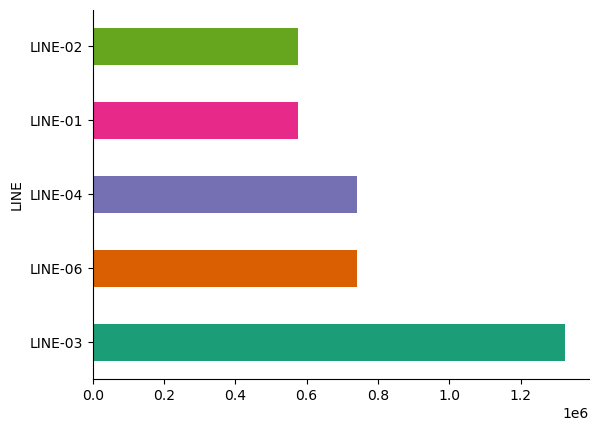

In [ ]:
df_prd['LINE'].value_counts().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)


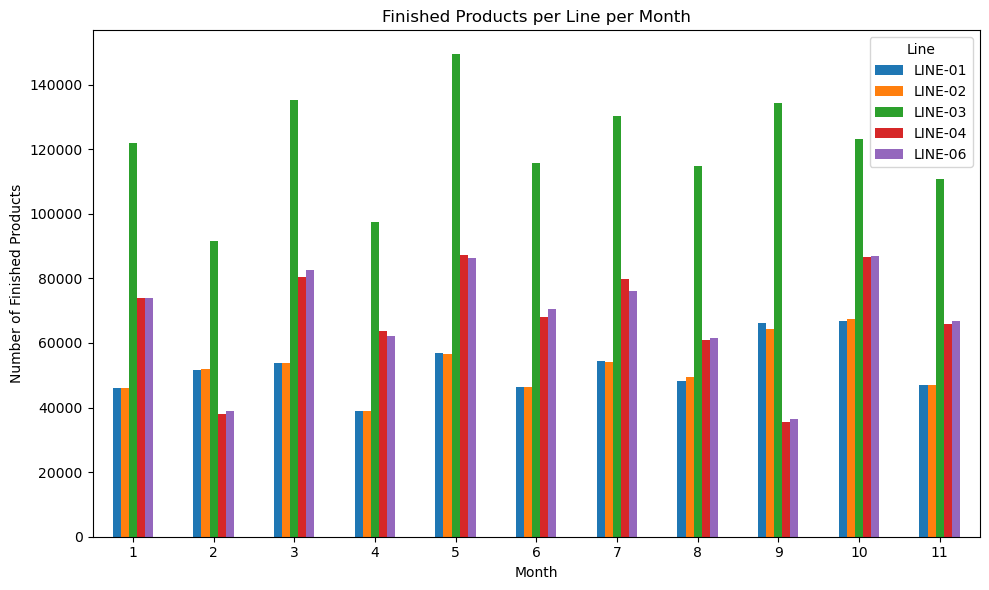

In [ ]:
# Convert 'FINISH_DATETIME' to datetime objects
df_prd['FINISH_DATETIME'] = pd.to_datetime(df_prd['FINISH_DATETIME'])

# Extract month from 'FINISH_DATETIME'
df_prd['month'] = df_prd['FINISH_DATETIME'].dt.month

# Group data by month and line
monthly_line_counts = df_prd.groupby(['month', 'LINE']).size().unstack()

# Plotting
monthly_line_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Finished Products per Line per Month')
plt.xlabel('Month')
plt.ylabel('Number of Finished Products')
plt.xticks(rotation=0)
plt.legend(title='Line')
plt.tight_layout()
plt.show()

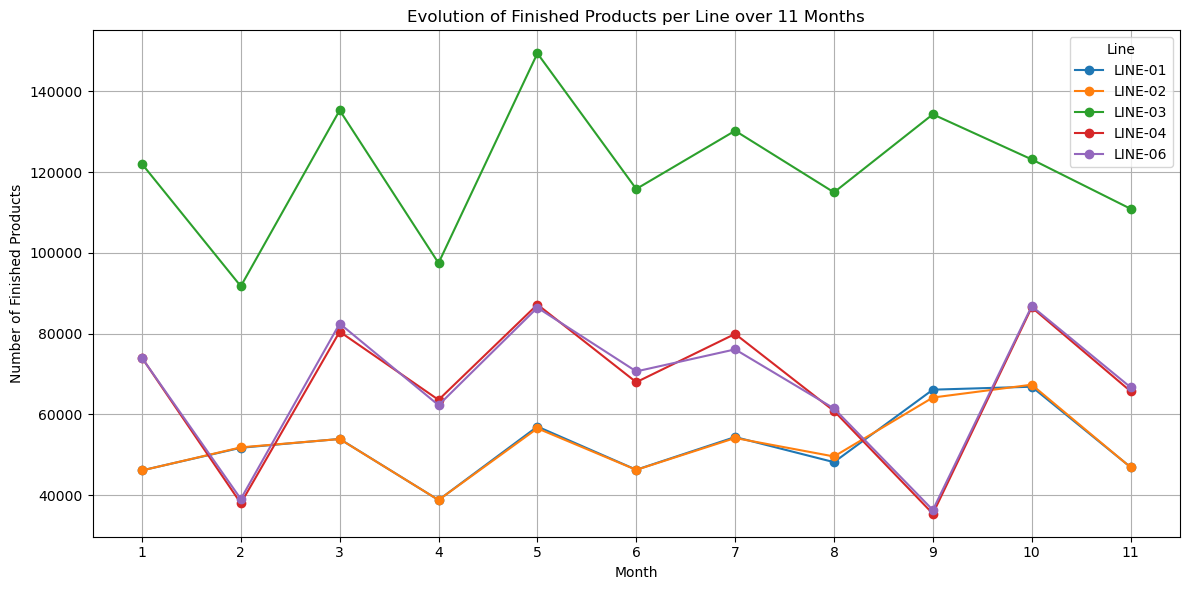

In [ ]:
# Convert 'START_DATETIME' and 'FINISH_DATETIME' to datetime objects if not already
df_prd['START_DATETIME'] = pd.to_datetime(df_prd['START_DATETIME'])
df_prd['FINISH_DATETIME'] = pd.to_datetime(df_prd['FINISH_DATETIME'])

# Extract month from 'FINISH_DATETIME'
df_prd['month'] = df_prd['FINISH_DATETIME'].dt.month

# Group data by month and line
monthly_line_counts = df_prd.groupby(['month', 'LINE']).size().unstack()

# Plotting
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

for line in monthly_line_counts.columns:
    plt.plot(monthly_line_counts.index, monthly_line_counts[line], label=line, marker='o')

plt.title('Evolution of Finished Products per Line over 11 Months')
plt.xlabel('Month')
plt.ylabel('Number of Finished Products')
plt.xticks(monthly_line_counts.index)  # Show all month ticks
plt.legend(title='Line')
plt.grid(True)
plt.tight_layout()
plt.show()

# Preparing the data and calculating the OEE

Define Status Categories

In [ ]:
scheduled_stops = ["Meeting", "Cleaning(5S)", "Break Time", "Lunch Break", "Other"]
production_status = ["Production"]
unexpected_stops = [
    "FF Check", "Awaiting Instruction", "Awaiting Materials", "Change Over",
    "Machine Failure", "Quality Check", "Machine Inspection", "Awaiting Box"
]
no_plan = ["No Plan"]
end_ops = ["End Of Operations"]

Create a mapping dictionary from status name to category name

In [ ]:
status_to_category_map = {}
for status in scheduled_stops:
    status_to_category_map[status] = "Scheduled Stop"
for status in production_status:
    status_to_category_map[status] = "Production"
for status in unexpected_stops:
    status_to_category_map[status] = "Unexpected Stop"
for status in no_plan:
    status_to_category_map[status] = "No Plan"
for status in end_ops:
    status_to_category_map[status] = "End Of Operations"

Theoretical Cycle Times (seconds)

In [ ]:
cycle_times = {
    'LINE-01': 11.0,
    'LINE-02': 11.0,
    'LINE-03': 5.5,
    'LINE-04': 11.0,
    'LINE-05': 11.0, # Note: LINE-05 not in data
    'LINE-06': 11.0
}

In [ ]:
# Ensure START_DATETIME and FINISH_DATETIME are datetimes (redundant if already done)
df_ls['FINISH_DATETIME'] = pd.to_datetime(df_ls['FINISH_DATETIME'])
df_prd['FINISH_DATETIME'] = pd.to_datetime(df_prd['FINISH_DATETIME'])

# Explicitly calculate DURATION as Timedelta
df_ls['DURATION'] = df_ls['FINISH_DATETIME'] - df_ls.index

# Check the dtype to confirm
print(f"DURATION column dtype: {df_ls['DURATION'].dtype}")

# Now, calculate Duration_Seconds
df_ls['Duration_Seconds'] = df_ls['DURATION'].dt.total_seconds()

# Add 'Date' column to status data (using START_DATETIME)
df_ls['Date'] = df_ls.index.date

# Add 'Date' column to production data (using FINISH_DATETIME as it signifies completion)
df_prd['Date'] = df_prd['FINISH_DATETIME'].dt.date

DURATION column dtype: timedelta64[ns]


-- Availability --
- Availability = Actual Run Time / Planned Production Time

-- Performance --
- Performance = (Total Actual Output * Ideal Cycle Time) / Actual Run Time Performance = Ideal Run Time / Actual Run Time

-- Quality --
- Quality = Good Count / Total Count
* NOTE: We assumed that ALL Total_Actual_Output are 'Good' items.

Calculate Daily Planned Production Time and Actual Run Time

In [ ]:
planned_statuses = ['Production', 'Scheduled Stop', 'Unexpected Stop']

df_planned_time = df_ls[df_ls['STATUS_NAME'].isin(planned_statuses)]

# Calculate total Planned Production Time per line per day
daily_planned_time = df_planned_time.groupby(['PRODUCTION_LINE', 'Date'])['Duration_Seconds'].sum().reset_index()
daily_planned_time = daily_planned_time.rename(columns={'Duration_Seconds': 'Planned_Production_Time_Seconds'})

# Calculate Actual Run Time (only 'Production' status) per line per day
df_run_time = df_ls[df_ls['STATUS_NAME'] == 'Production']
daily_run_time = df_run_time.groupby(['PRODUCTION_LINE', 'Date'])['Duration_Seconds'].sum().reset_index()
daily_run_time = daily_run_time.rename(columns={'Duration_Seconds': 'Actual_Run_Time_Seconds'})

# Merge planned and run times
# Use outer merge here to capture days where there was planned time but zero run time, or vice-versa (less common)
daily_times = pd.merge(daily_planned_time, daily_run_time, on=['PRODUCTION_LINE', 'Date'], how='outer')

# Fill NaN for run time with 0 (if a line had planned time but zero production status time)
# Also fill NaN for planned time with 0 (if somehow only run time existed - less likely but possible)
daily_times['Planned_Production_Time_Seconds'] = daily_times['Planned_Production_Time_Seconds'].fillna(0)
daily_times['Actual_Run_Time_Seconds'] = daily_times['Actual_Run_Time_Seconds'].fillna(0)

Calculate Daily Actual Output

In [ ]:
daily_output = df_prd.groupby(['LINE', 'Date']).size().reset_index(name='Total_Actual_Output')
daily_output = daily_output.rename(columns={'LINE': 'PRODUCTION_LINE'})

Merge Time Data and Output Data

In [ ]:
# Merge the time calculations with the output counts
daily_oee_data = pd.merge(daily_times, daily_output, on=['PRODUCTION_LINE', 'Date'], how='outer')

# Fill NaN values resulting from the outer merge
# If no time data, planned/run time is 0. If no output data, output is 0.
daily_oee_data['Planned_Production_Time_Seconds'] = daily_oee_data['Planned_Production_Time_Seconds'].fillna(0)
daily_oee_data['Actual_Run_Time_Seconds'] = daily_oee_data['Actual_Run_Time_Seconds'].fillna(0)
daily_oee_data['Total_Actual_Output'] = daily_oee_data['Total_Actual_Output'].fillna(0).astype(int)

Calculate OEE Components

In [ ]:
# Add Ideal Cycle Time based on Production Line
daily_oee_data['Ideal_Cycle_Time_Seconds'] = daily_oee_data['PRODUCTION_LINE'].map(cycle_times)
# Handle cases where a line in the data might not be in cycle_times map
missing_cycle_time_lines = daily_oee_data[daily_oee_data['Ideal_Cycle_Time_Seconds'].isna()]['PRODUCTION_LINE'].unique()
if len(missing_cycle_time_lines) > 0:
    print(f"\nWarning: Ideal Cycle Time not found for lines: {missing_cycle_time_lines}. Performance and OEE cannot be calculated for these lines/days.")


# -- Availability --
# Availability = Actual Run Time / Planned Production Time
daily_oee_data['Availability'] = np.where(
    daily_oee_data['Planned_Production_Time_Seconds'] > 0,
    daily_oee_data['Actual_Run_Time_Seconds'] / daily_oee_data['Planned_Production_Time_Seconds'],
    0  # Assign 0 if Planned Production Time is zero
)

# -- Performance --
# Performance = (Total Actual Output * Ideal Cycle Time) / Actual Run Time
# Performance = Ideal Run Time / Actual Run Time
daily_oee_data['Performance'] = np.where(
    # Check for non-zero run time AND non-null ideal cycle time
    (daily_oee_data['Actual_Run_Time_Seconds'] > 0) & (daily_oee_data['Ideal_Cycle_Time_Seconds'].notna()),
    (daily_oee_data['Total_Actual_Output'] * daily_oee_data['Ideal_Cycle_Time_Seconds']) / daily_oee_data['Actual_Run_Time_Seconds'],
    0 # Assign 0 if Actual Run Time is zero or Ideal Cycle Time is missing
)

# Cap performance at 1 (or slightly higher like 1.05) if needed, as >1 often indicates cycle time inaccuracy
# daily_oee_data['Performance'] = daily_oee_data['Performance'].clip(upper=1.0) # Optional capping

# -- Quality --
# Quality = Good Count / Total Count
# *** NOTE: We assumed that ALL Total_Actual_Output are 'Good' items. ***
# *** (Good Count = Total_Actual_Output - Scrap_Count) and use that here. ***
# Good Count = Total_Actual_Output (in this simplified version)
daily_oee_data['Quality'] = np.where(
    daily_oee_data['Total_Actual_Output'] > 0,
    1.0, # Assign 1 (100%) if any production occurred (assuming all good)
    0 # Assign 0 if no production occurred (cannot have quality without output)
    # If Total_Actual_Output is 0, OEE will be 0 anyway because Performance will be 0.
    # Setting Quality to 0 here is consistent. Alternatively, could use 1 or NaN if preferred.
)



Calculate Final OEE

In [ ]:
# OEE = Availability * Performance * Quality
daily_oee_data['OEE'] = daily_oee_data['Availability'] * daily_oee_data['Performance'] * daily_oee_data['Quality']


Final Formatting and Output

In [ ]:
final_columns = [
    'PRODUCTION_LINE',
    'Date',
    'Planned_Production_Time_Seconds',
    'Actual_Run_Time_Seconds',
    'Total_Actual_Output',
    'Ideal_Cycle_Time_Seconds',
    'Availability',
    'Performance',
    'Quality',
    'OEE'
]
# Ensure all required columns exist before selecting
existing_cols = [col for col in final_columns if col in daily_oee_data.columns]
daily_oee_results = daily_oee_data[existing_cols].copy()

# Convert Date back to datetime object if needed (it became object type during merge sometimes)
daily_oee_results['Date'] = pd.to_datetime(daily_oee_results['Date'])

# Sort results
daily_oee_results = daily_oee_results.sort_values(by=['PRODUCTION_LINE', 'Date']).reset_index(drop=True)

# --- Display Results ---
print(f"\nCalculated Daily OEE for {daily_oee_results['Date'].nunique()} days across {daily_oee_results['PRODUCTION_LINE'].nunique()} lines.")
print("\nSample Daily OEE Results (First 7 rows):")
display(daily_oee_results.head(7))

# --- Save Results ---
output_filename = 'daily_oee_report.csv'
# daily_oee_results.to_csv(output_filename, index=False)
print(f"\nSuccessfully saved OEE results to {output_filename}")


Calculated Daily OEE for 259 days across 5 lines.

Sample Daily OEE Results (First 7 rows):


,PRODUCTION_LINE,Date,Planned_Production_Time_Seconds,Actual_Run_Time_Seconds,Total_Actual_Output,Ideal_Cycle_Time_Seconds,Availability,Performance,Quality,OEE
0,LINE-01,2023-01-02,14520.0,14520.0,1177,11.0,1.0,0.891667,1.0,0.891667
1,LINE-01,2023-01-03,24780.0,24780.0,1976,11.0,1.0,0.877159,1.0,0.877159
2,LINE-01,2023-01-04,24420.0,24420.0,1977,11.0,1.0,0.890541,1.0,0.890541
3,LINE-01,2023-01-05,24300.0,24300.0,1976,11.0,1.0,0.894486,1.0,0.894486
4,LINE-01,2023-01-06,18240.0,18240.0,1534,11.0,1.0,0.925110,1.0,0.925110
5,LINE-01,2023-01-07,23580.0,23580.0,1791,11.0,1.0,0.835496,1.0,0.835496
6,LINE-01,2023-01-09,23760.0,23760.0,1976,11.0,1.0,0.914815,1.0,0.914815



Successfully saved OEE results to daily_oee_report.csv


Save OEE Data per Production Line to Separate Files

In [ ]:
unique_production_lines = daily_oee_results['PRODUCTION_LINE'].unique()
print(unique_production_lines)

for line in unique_production_lines:
    df_line_specific = daily_oee_results[daily_oee_results['PRODUCTION_LINE'] == line].copy()
    file_name = f"daily_oee_report_{line}.csv"
    df_line_specific.to_csv(file_name, index=False)

['LINE-01' 'LINE-02' 'LINE-03' 'LINE-04' 'LINE-06']


In [ ]:
# Group by date and sum time/output metrics
grouped = daily_oee_results.groupby('Date').agg({
    'Planned_Production_Time_Seconds': 'sum',
    'Actual_Run_Time_Seconds': 'sum',
    'Total_Actual_Output': 'sum',
    'Ideal_Cycle_Time_Seconds': 'mean'  # Average across lines
}).reset_index()

# Calculate metrics
grouped['Availability'] = grouped['Actual_Run_Time_Seconds'] / grouped['Planned_Production_Time_Seconds']
grouped['Performance'] = (grouped['Ideal_Cycle_Time_Seconds'] * grouped['Total_Actual_Output']) / grouped['Actual_Run_Time_Seconds']
grouped['Quality'] = 1.0  # Assuming all output is good
grouped['OEE'] = grouped['Availability'] * grouped['Performance'] * grouped['Quality']

# Final DataFrame: one row per day, overall OEE for that day
overall_daily_oee = grouped[['Date', 'Availability', 'Performance', 'Quality', 'OEE']]

# Display
display(overall_daily_oee)
# Save
overall_daily_oee.to_csv("overall_daily_oee.csv", index=False)

          Date  Availability  Performance  Quality       OEE
0   2023-01-02           1.0     1.126069      1.0  1.126069
1   2023-01-03           1.0     1.051082      1.0  1.051082
2   2023-01-04           1.0     1.127245      1.0  1.127245
3   2023-01-05           1.0     1.240277      1.0  1.240277
4   2023-01-06           1.0     1.154885      1.0  1.154885
..         ...           ...          ...      ...       ...
254 2023-11-21           1.0     1.119781      1.0  1.119781
255 2023-11-22           1.0     1.140829      1.0  1.140829
256 2023-11-23           1.0     0.963893      1.0  0.963893
257 2023-11-24           1.0     0.806926      1.0  0.806926
258 2023-11-25           1.0    -0.003841      1.0 -0.003841

[259 rows x 5 columns]


OEE Trend per Line

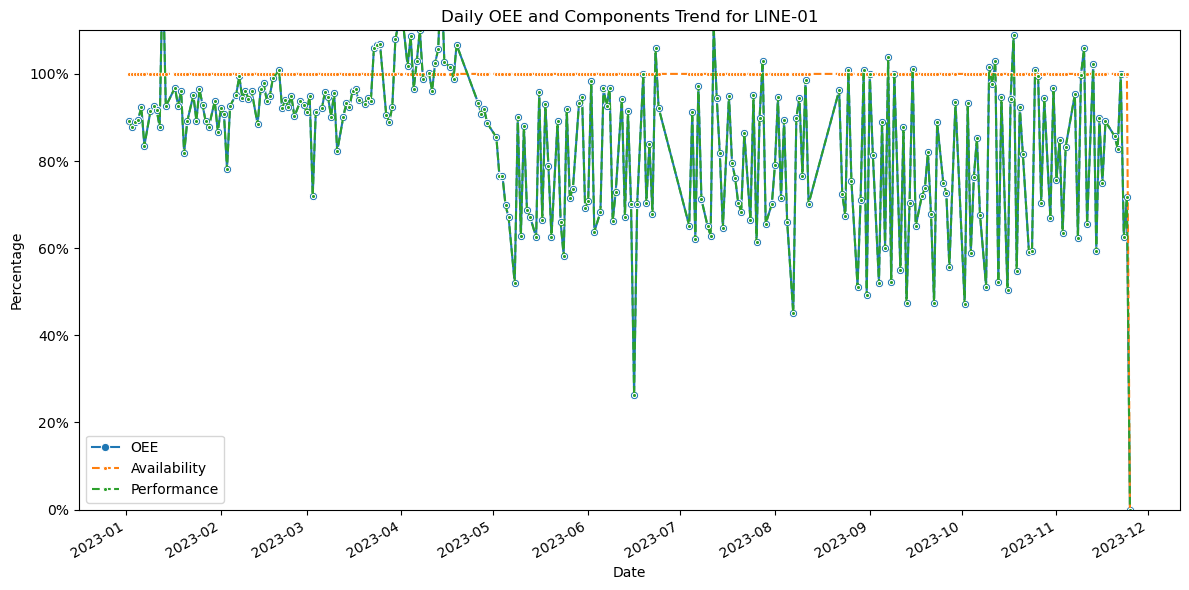

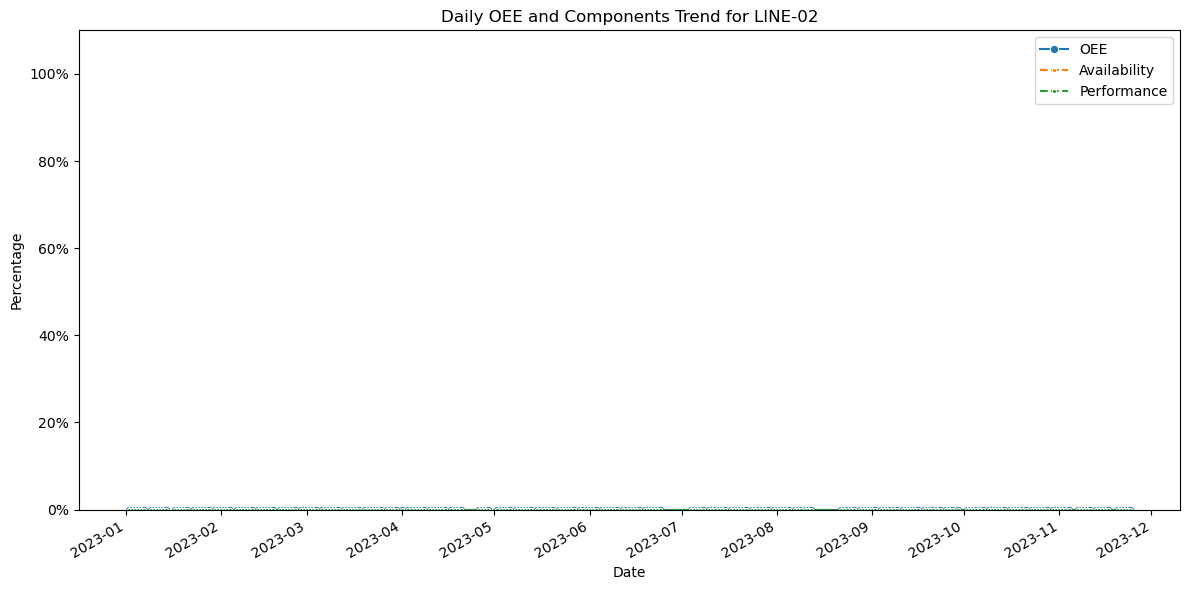

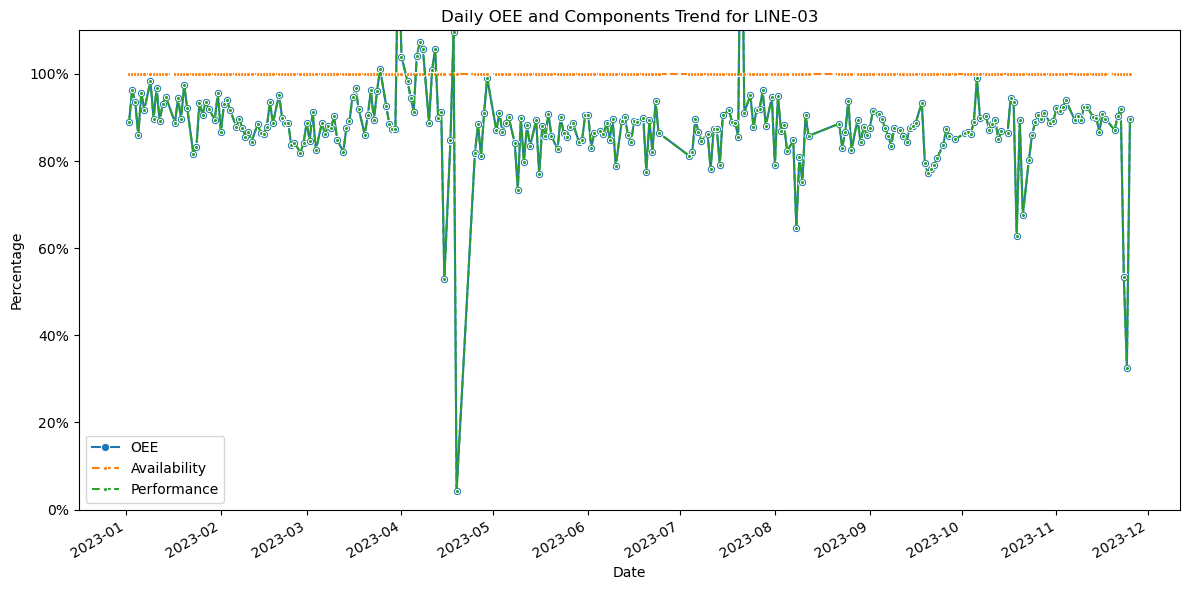

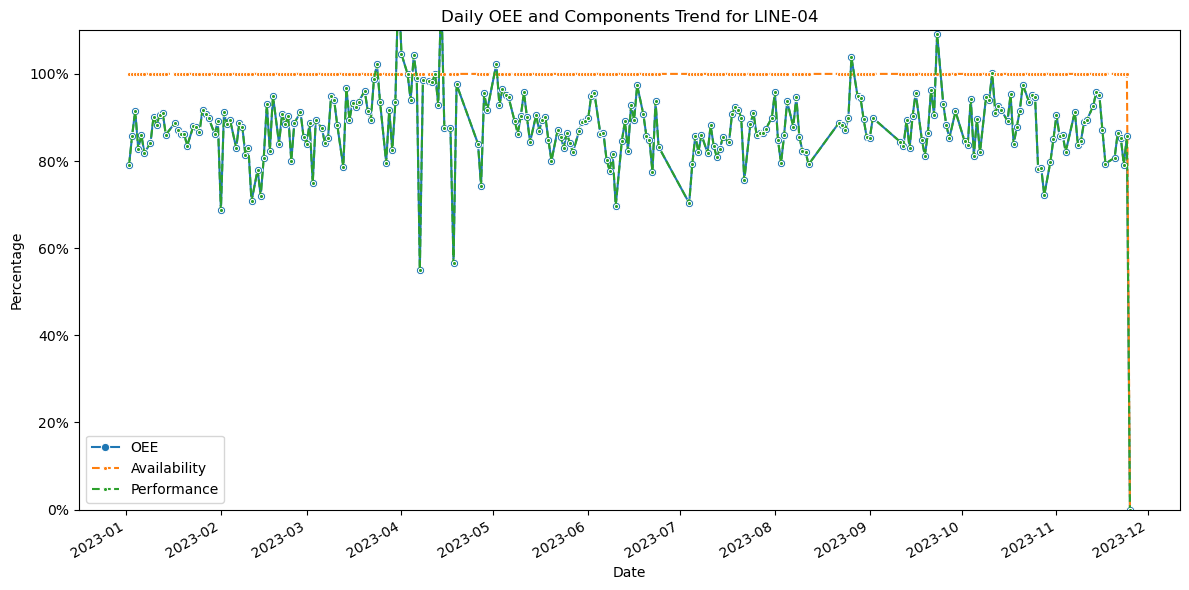

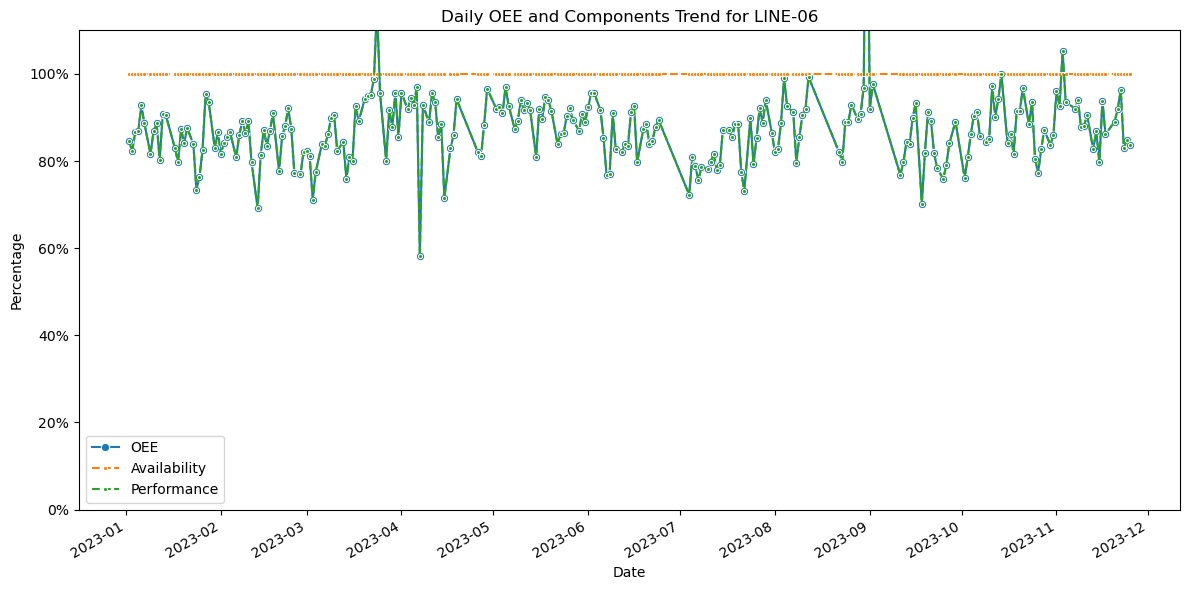

In [ ]:
import matplotlib.ticker as mtick
for line in unique_production_lines:
    df_line = daily_oee_results[daily_oee_results['PRODUCTION_LINE'] == line]

    fig, ax = plt.subplots(figsize=(12, 6))

    sns.lineplot(data=df_line, x='Date', y='OEE', ax=ax, marker='o', label='OEE')
    sns.lineplot(data=df_line, x='Date', y='Availability', ax=ax, marker='.', linestyle='--', label='Availability')
    sns.lineplot(data=df_line, x='Date', y='Performance', ax=ax, marker='.', linestyle='--', label='Performance')


    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylim(0, 1.1)
    ax.set_title(f'Daily OEE and Components Trend for {line}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Percentage')
    ax.legend()
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

Faceted OEE Comparison

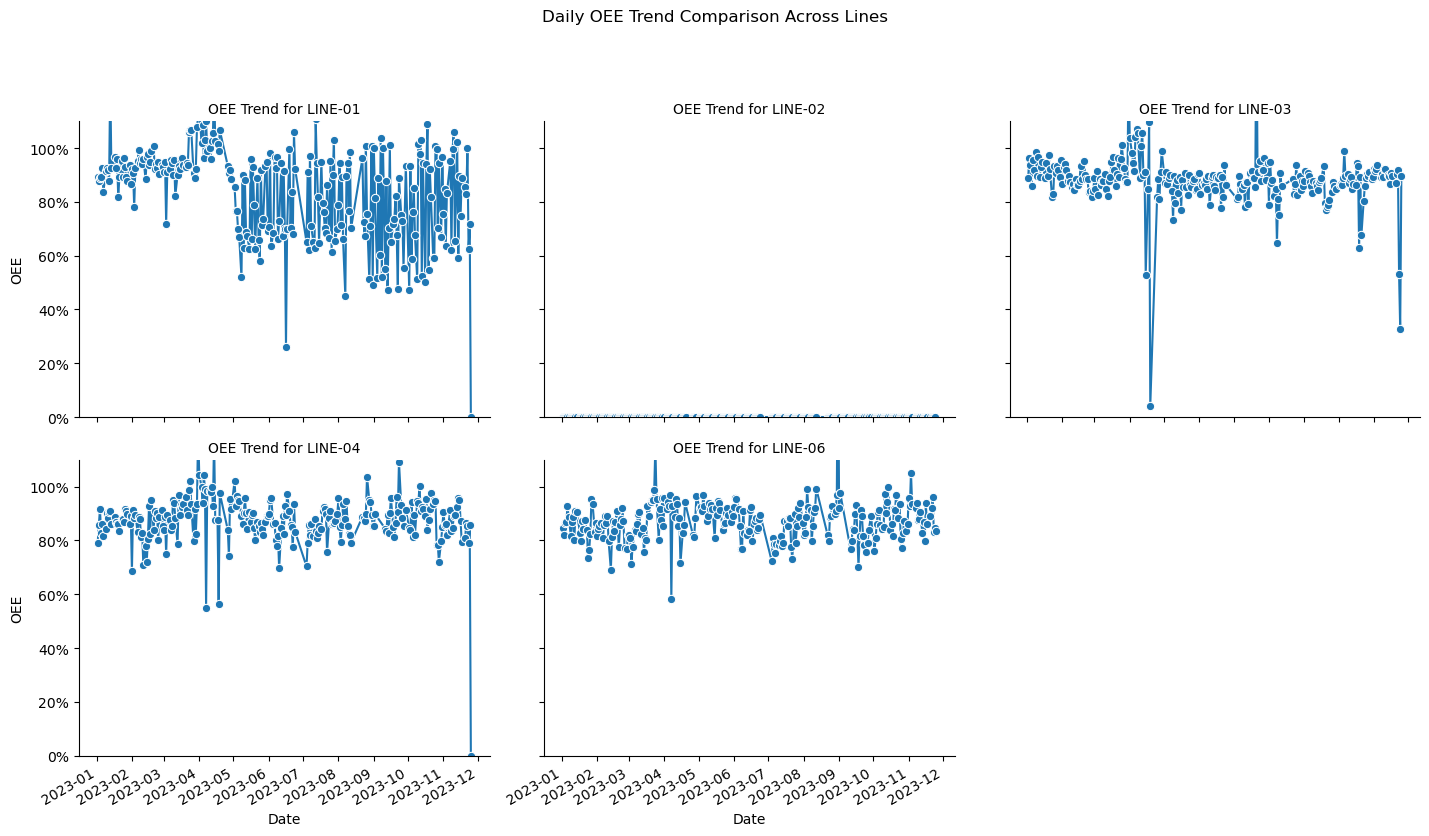

In [ ]:
num_lines = len(unique_production_lines)
wrap_cols = 3 if num_lines > 2 else num_lines

g = sns.relplot(
    data=daily_oee_results,
    x='Date',
    y='OEE',
    col='PRODUCTION_LINE',
    kind='line',
    col_wrap=wrap_cols,
    marker='o',
    height=4,
    aspect=1.2,
    facet_kws={'sharey': True}
)


g.set_titles("OEE Trend for {col_name}")
g.set_axis_labels("Date", "OEE")
g.map_dataframe(lambda data, **kwargs: plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0)))
g.map_dataframe(lambda data, **kwargs: plt.gca().set_ylim(0, 1.1))
g.fig.autofmt_xdate(rotation=30)
g.fig.suptitle('Daily OEE Trend Comparison Across Lines', y=1.04)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Average OEE per Line

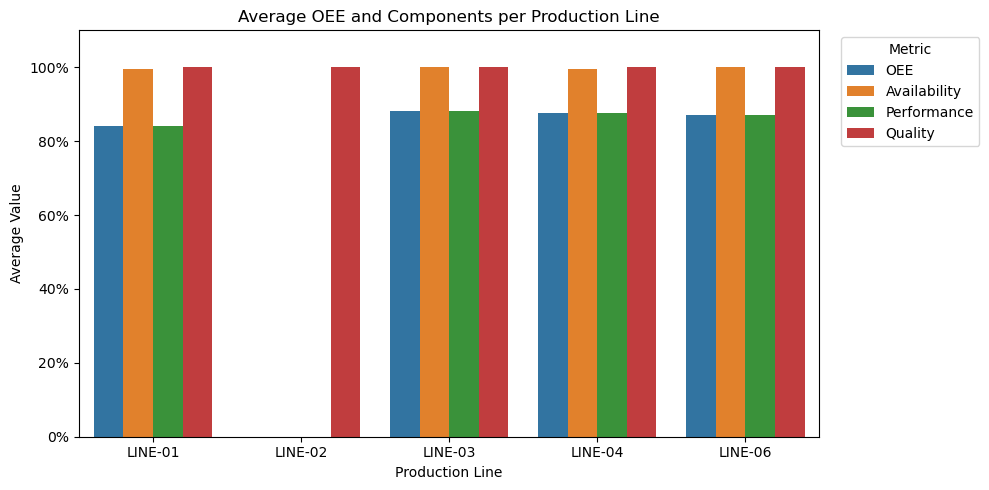

In [ ]:
avg_oee = daily_oee_results.groupby('PRODUCTION_LINE')[['OEE', 'Availability', 'Performance', 'Quality']].mean().reset_index()
avg_oee_melted = avg_oee.melt(id_vars='PRODUCTION_LINE', var_name='Metric', value_name='Average Value')

fig_avg, ax_avg = plt.subplots(figsize=(10, 5))
sns.barplot(data=avg_oee_melted, x='PRODUCTION_LINE', y='Average Value', hue='Metric', ax=ax_avg)

ax_avg.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax_avg.set_ylim(0, 1.1)
ax_avg.set_title('Average OEE and Components per Production Line')
ax_avg.set_xlabel('Production Line')
ax_avg.set_ylabel('Average Value')
ax_avg.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()


plt.show()


Conclusion: